In [1]:
# =============================================================================
# NOTEBOOK 05: CHURN PREDICTION
# =============================================================================
# Project: Retail Predictive Analytics Suite
# Author: [Your Name]
# Date: 2024
# Objective: Predict customer churn using classification models
# =============================================================================

# =============================================================================
# CELL 1: IMPORT LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)

# Explainability
import shap

# Model Persistence
import joblib

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Libraries imported successfully
Analysis Date: 2026-02-11 13:27


In [2]:
# =============================================================================
# CELL 2: LOAD DATA
# =============================================================================

# Load cleaned dataset
df = pd.read_csv('../data/processed/clean_retail.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Load RFM features
rfm = pd.read_csv('../data/processed/rfm_features.csv')

print("=" * 60)
print("DATA LOADED")
print("=" * 60)
print(f"Transaction Records: {len(df):,}")
print(f"Unique Customers: {df['Customer ID'].nunique():,}")
print(f"RFM Features: {len(rfm):,} customers")
print(f"Date Range: {df['InvoiceDate'].min().date()} to {df['InvoiceDate'].max().date()}")

DATA LOADED
Transaction Records: 779,425
Unique Customers: 5,878
RFM Features: 5,878 customers
Date Range: 2009-12-01 to 2011-12-09


CHURN DEFINITION
Reference Date: 2011-12-09
Churn Threshold: 90 days

Churn Definition:
------------------------------------------------------------
Churned (1): Customer has not purchased in last 90 days
Active (0): Customer has purchased within last 90 days

Churn Distribution:
------------------------------------------------------------
Active Customers (0): 2,889 (49.1%)
Churned Customers (1): 2,989 (50.9%)


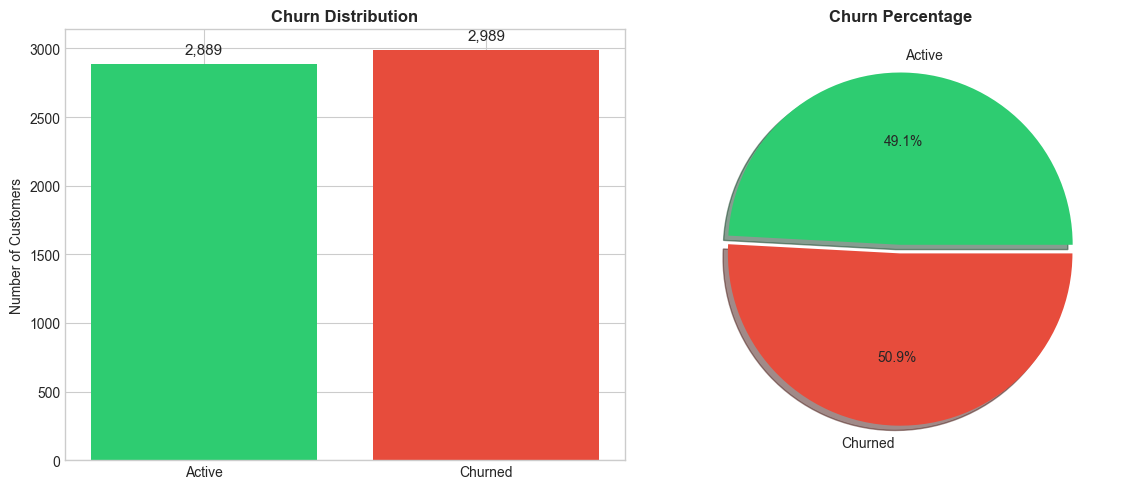


Plot saved: outputs/churn/churn_distribution.png


In [3]:
# =============================================================================
# CELL 3: DEFINE CHURN
# =============================================================================

print("=" * 60)
print("CHURN DEFINITION")
print("=" * 60)

# Reference date
reference_date = df['InvoiceDate'].max()
print(f"Reference Date: {reference_date.date()}")

# Define churn threshold (90 days of inactivity)
CHURN_THRESHOLD = 90

print(f"Churn Threshold: {CHURN_THRESHOLD} days")
print("\nChurn Definition:")
print("-" * 60)
print(f"Churned (1): Customer has not purchased in last {CHURN_THRESHOLD} days")
print(f"Active (0): Customer has purchased within last {CHURN_THRESHOLD} days")

# Create churn label based on Recency
rfm['Churn'] = (rfm['Recency'] > CHURN_THRESHOLD).astype(int)

# Churn distribution
churn_counts = rfm['Churn'].value_counts()
print(f"\nChurn Distribution:")
print("-" * 60)
print(f"Active Customers (0): {churn_counts[0]:,} ({churn_counts[0]/len(rfm)*100:.1f}%)")
print(f"Churned Customers (1): {churn_counts[1]:,} ({churn_counts[1]/len(rfm)*100:.1f}%)")

# Visualize churn distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
ax1 = axes[0]
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(['Active', 'Churned'], [churn_counts[0], churn_counts[1]], color=colors)
ax1.set_title('Churn Distribution', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Customers')
for bar, val in zip(bars, [churn_counts[0], churn_counts[1]]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{val:,}', ha='center', va='bottom', fontsize=11)

# Pie chart
ax2 = axes[1]
ax2.pie([churn_counts[0], churn_counts[1]], labels=['Active', 'Churned'],
        autopct='%1.1f%%', colors=colors, explode=[0, 0.05], shadow=True)
ax2.set_title('Churn Percentage', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/churn/churn_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/churn/churn_distribution.png")

In [4]:
# =============================================================================
# CELL 4: FEATURE ENGINEERING
# =============================================================================

print("=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# Create customer-level features from transaction data
customer_features = df.groupby('Customer ID').agg({
    # Basic RFM already in rfm dataframe
    
    # Order patterns
    'Invoice': 'nunique',
    'Quantity': ['sum', 'mean', 'std'],
    'Revenue': ['sum', 'mean', 'std', 'max', 'min'],
    'Price': ['mean', 'std', 'max', 'min'],
    
    # Product diversity
    'StockCode': 'nunique',
    'Description': 'nunique',
    
    # Time patterns
    'Hour': ['mean', 'std'],
    'DayOfWeek': lambda x: x.mode()[0] if len(x.mode()) > 0 else 0,
    
    # Country
    'Country': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
}).reset_index()

# Flatten column names
customer_features.columns = [
    'CustomerID',
    'TotalOrders',
    'TotalQuantity', 'AvgQuantity', 'StdQuantity',
    'TotalRevenue', 'AvgRevenue', 'StdRevenue', 'MaxRevenue', 'MinRevenue',
    'AvgPrice', 'StdPrice', 'MaxPrice', 'MinPrice',
    'UniqueProducts', 'UniqueDescriptions',
    'AvgHour', 'StdHour',
    'PreferredDay',
    'Country'
]

# Fill NaN in std columns with 0
std_cols = ['StdQuantity', 'StdRevenue', 'StdPrice', 'StdHour']
customer_features[std_cols] = customer_features[std_cols].fillna(0)

print(f"Created {len(customer_features.columns)-1} features for {len(customer_features):,} customers")
print("\nFeatures Created:")
for col in customer_features.columns[1:]:
    print(f"  - {col}")

FEATURE ENGINEERING
Created 19 features for 5,878 customers

Features Created:
  - TotalOrders
  - TotalQuantity
  - AvgQuantity
  - StdQuantity
  - TotalRevenue
  - AvgRevenue
  - StdRevenue
  - MaxRevenue
  - MinRevenue
  - AvgPrice
  - StdPrice
  - MaxPrice
  - MinPrice
  - UniqueProducts
  - UniqueDescriptions
  - AvgHour
  - StdHour
  - PreferredDay
  - Country


In [5]:
# =============================================================================
# CELL 5: ADDITIONAL DERIVED FEATURES
# =============================================================================

print("=" * 60)
print("ADDITIONAL DERIVED FEATURES")
print("=" * 60)

# Calculate additional features
customer_features['AvgOrderValue'] = customer_features['TotalRevenue'] / customer_features['TotalOrders']
customer_features['AvgItemsPerOrder'] = customer_features['TotalQuantity'] / customer_features['TotalOrders']
customer_features['ProductDiversity'] = customer_features['UniqueProducts'] / customer_features['TotalOrders']
customer_features['RevenueRange'] = customer_features['MaxRevenue'] - customer_features['MinRevenue']
customer_features['PriceRange'] = customer_features['MaxPrice'] - customer_features['MinPrice']

# Calculate purchase frequency (orders per month of activity)
first_last = df.groupby('Customer ID').agg({
    'InvoiceDate': ['min', 'max']
}).reset_index()
first_last.columns = ['CustomerID', 'FirstPurchase', 'LastPurchase']
first_last['ActiveDays'] = (first_last['LastPurchase'] - first_last['FirstPurchase']).dt.days + 1
first_last['ActiveMonths'] = first_last['ActiveDays'] / 30

customer_features = customer_features.merge(first_last[['CustomerID', 'ActiveDays', 'ActiveMonths']], on='CustomerID')
customer_features['OrdersPerMonth'] = customer_features['TotalOrders'] / customer_features['ActiveMonths'].clip(lower=1)

print("Additional Features Created:")
print("  - AvgOrderValue")
print("  - AvgItemsPerOrder")
print("  - ProductDiversity")
print("  - RevenueRange")
print("  - PriceRange")
print("  - ActiveDays")
print("  - ActiveMonths")
print("  - OrdersPerMonth")

print(f"\nTotal Features: {len(customer_features.columns)-1}")

ADDITIONAL DERIVED FEATURES
Additional Features Created:
  - AvgOrderValue
  - AvgItemsPerOrder
  - ProductDiversity
  - RevenueRange
  - PriceRange
  - ActiveDays
  - ActiveMonths
  - OrdersPerMonth

Total Features: 27


In [6]:
# =============================================================================
# CELL 6: MERGE WITH RFM AND PREPARE FINAL DATASET
# =============================================================================

print("=" * 60)
print("PREPARE FINAL DATASET")
print("=" * 60)

# Merge customer features with RFM
churn_data = rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Segment', 'Churn']].merge(
    customer_features,
    on='CustomerID',
    how='left'
)

# Encode categorical variables
# Country encoding
le_country = LabelEncoder()
churn_data['Country_Encoded'] = le_country.fit_transform(churn_data['Country'].fillna('Unknown'))

# Segment encoding
le_segment = LabelEncoder()
churn_data['Segment_Encoded'] = le_segment.fit_transform(churn_data['Segment'])

print(f"Final Dataset Shape: {churn_data.shape}")
print(f"Total Features: {churn_data.shape[1] - 2}")  # Exclude CustomerID and Churn

# Display sample
print("\nSample Data:")
display(churn_data.head())

# Check for missing values
print("\nMissing Values:")
missing = churn_data.isnull().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print(missing)
else:
    print("No missing values")

PREPARE FINAL DATASET
Final Dataset Shape: (5878, 35)
Total Features: 33

Sample Data:


,CustomerID,Recency,Frequency,Monetary,Segment,Churn,TotalOrders,TotalQuantity,AvgQuantity,StdQuantity,TotalRevenue,AvgRevenue,StdRevenue,MaxRevenue,MinRevenue,AvgPrice,StdPrice,MaxPrice,MinPrice,UniqueProducts,UniqueDescriptions,AvgHour,StdHour,PreferredDay,Country,AvgOrderValue,AvgItemsPerOrder,ProductDiversity,RevenueRange,PriceRange,ActiveDays,ActiveMonths,OrdersPerMonth,Country_Encoded,Segment_Encoded
0,12346,326,12,77556.4600,Champions,1,12,74285,2184.8529,12727.4039,77556.4600,2281.0724,13234.9434,77183.6000,1.0000,6.1000,1.8831,7.4900,1.0000,27,26,12.2353,1.4783,0,United Kingdom,6463.0383,6190.4167,2.2500,77182.6000,6.4900,401,13.3667,0.8978,38,0
1,12347,2,8,4921.5300,Champions,0,8,2967,13.3649,17.3374,4921.5300,22.1691,21.4677,249.6000,5.0400,2.4981,2.2305,12.7500,0.2500,126,126,12.5180,2.0241,1,Iceland,615.1912,370.8750,15.7500,244.5600,12.5000,403,13.4333,0.5955,16,0
2,12348,75,5,2019.4000,Hibernating,0,5,2714,53.2157,48.7008,2019.4000,39.5961,44.2055,240.0000,1.0000,3.7863,10.6771,40.0000,0.2900,25,28,14.7451,3.3932,0,Finland,403.8800,542.8000,5.0000,239.0000,39.7100,363,12.1000,0.4132,12,1
3,12349,19,4,4428.6900,New Customers,0,4,1624,9.2800,7.7709,4428.6900,25.3068,33.7614,300.0000,6.6400,8.4597,32.8082,300.0000,0.4200,138,145,9.7371,1.9999,3,Italy,1107.1725,406.0000,34.5000,293.3600,299.5800,571,19.0333,0.2102,18,2
4,12350,310,1,334.4000,Hibernating,1,1,197,11.5882,4.3454,334.4000,19.6706,7.2755,40.0000,8.5000,3.8412,9.3348,40.0000,0.8500,17,17,16.0000,0.0000,2,Norway,334.4000,197.0000,17.0000,31.5000,39.1500,1,0.0333,1.0000,26,1



Missing Values:
No missing values


In [7]:
# =============================================================================
# CELL 7: SELECT FEATURES FOR MODELING
# =============================================================================

print("=" * 60)
print("FEATURE SELECTION")
print("=" * 60)

# Define feature columns (exclude identifiers and target)
exclude_cols = ['CustomerID', 'Churn', 'Country', 'Segment']
feature_cols = [col for col in churn_data.columns if col not in exclude_cols]

# Remove Recency as it directly defines churn (data leakage)
feature_cols.remove('Recency')

print("Features Selected for Modeling:")
print("-" * 60)
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2}. {col}")

print(f"\nTotal Features: {len(feature_cols)}")

# Prepare X and y
X = churn_data[feature_cols].copy()
y = churn_data['Churn'].copy()

# Handle any remaining missing values
X = X.fillna(0)

# Handle infinite values
X = X.replace([np.inf, -np.inf], 0)

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Shape: {y.shape}")
print(f"Target Distribution: {y.value_counts().to_dict()}")

FEATURE SELECTION
Features Selected for Modeling:
------------------------------------------------------------
   1. Frequency
   2. Monetary
   3. TotalOrders
   4. TotalQuantity
   5. AvgQuantity
   6. StdQuantity
   7. TotalRevenue
   8. AvgRevenue
   9. StdRevenue
  10. MaxRevenue
  11. MinRevenue
  12. AvgPrice
  13. StdPrice
  14. MaxPrice
  15. MinPrice
  16. UniqueProducts
  17. UniqueDescriptions
  18. AvgHour
  19. StdHour
  20. PreferredDay
  21. AvgOrderValue
  22. AvgItemsPerOrder
  23. ProductDiversity
  24. RevenueRange
  25. PriceRange
  26. ActiveDays
  27. ActiveMonths
  28. OrdersPerMonth
  29. Country_Encoded
  30. Segment_Encoded

Total Features: 30

Feature Matrix Shape: (5878, 30)
Target Shape: (5878,)
Target Distribution: {1: 2989, 0: 2889}


In [8]:
# =============================================================================
# CELL 8: TRAIN-TEST SPLIT
# =============================================================================

print("=" * 60)
print("TRAIN-TEST SPLIT")
print("=" * 60)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set: {len(X_train):,} samples")
print(f"Test Set: {len(X_test):,} samples")

print(f"\nTraining Set Class Distribution:")
train_dist = y_train.value_counts()
print(f"  Active (0): {train_dist[0]:,} ({train_dist[0]/len(y_train)*100:.1f}%)")
print(f"  Churned (1): {train_dist[1]:,} ({train_dist[1]/len(y_train)*100:.1f}%)")

print(f"\nTest Set Class Distribution:")
test_dist = y_test.value_counts()
print(f"  Active (0): {test_dist[0]:,} ({test_dist[0]/len(y_test)*100:.1f}%)")
print(f"  Churned (1): {test_dist[1]:,} ({test_dist[1]/len(y_test)*100:.1f}%)")

TRAIN-TEST SPLIT
Training Set: 4,702 samples
Test Set: 1,176 samples

Training Set Class Distribution:
  Active (0): 2,311 (49.1%)
  Churned (1): 2,391 (50.9%)

Test Set Class Distribution:
  Active (0): 578 (49.1%)
  Churned (1): 598 (50.9%)


In [9]:
# =============================================================================
# CELL 9: FEATURE SCALING
# =============================================================================

print("=" * 60)
print("FEATURE SCALING")
print("=" * 60)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to dataframe for interpretability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_cols)

print("Features scaled using StandardScaler")
print(f"Training data scaled: {X_train_scaled.shape}")
print(f"Test data scaled: {X_test_scaled.shape}")

# Save scaler
joblib.dump(scaler, '../models/churn_scaler.pkl')
print("\nScaler saved: models/churn_scaler.pkl")

FEATURE SCALING
Features scaled using StandardScaler
Training data scaled: (4702, 30)
Test data scaled: (1176, 30)

Scaler saved: models/churn_scaler.pkl


In [10]:
# =============================================================================
# CELL 10: MODEL 1 - LOGISTIC REGRESSION
# =============================================================================

print("=" * 60)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 60)

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("\nLogistic Regression Results:")
print("-" * 60)
print(f"Accuracy:  {accuracy_score(y_test, lr_pred):.4f}")
print(f"Precision: {precision_score(y_test, lr_pred):.4f}")
print(f"Recall:    {recall_score(y_test, lr_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, lr_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, lr_prob):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, lr_pred, target_names=['Active', 'Churned']))

MODEL 1: LOGISTIC REGRESSION

Logistic Regression Results:
------------------------------------------------------------
Accuracy:  0.8282
Precision: 0.8311
Recall:    0.8311
F1 Score:  0.8311
ROC-AUC:   0.8734

Classification Report:
              precision    recall  f1-score   support

      Active       0.83      0.83      0.83       578
     Churned       0.83      0.83      0.83       598

    accuracy                           0.83      1176
   macro avg       0.83      0.83      0.83      1176
weighted avg       0.83      0.83      0.83      1176



In [11]:
# =============================================================================
# CELL 11: MODEL 2 - RANDOM FOREST
# =============================================================================

print("=" * 60)
print("MODEL 2: RANDOM FOREST")
print("=" * 60)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# Predictions
rf_pred = rf_model.predict(X_test_scaled)
rf_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("\nRandom Forest Results:")
print("-" * 60)
print(f"Accuracy:  {accuracy_score(y_test, rf_pred):.4f}")
print(f"Precision: {precision_score(y_test, rf_pred):.4f}")
print(f"Recall:    {recall_score(y_test, rf_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, rf_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, rf_prob):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=['Active', 'Churned']))

MODEL 2: RANDOM FOREST

Random Forest Results:
------------------------------------------------------------
Accuracy:  0.9201
Precision: 0.8950
Recall:    0.9548
F1 Score:  0.9239
ROC-AUC:   0.9567

Classification Report:
              precision    recall  f1-score   support

      Active       0.95      0.88      0.92       578
     Churned       0.89      0.95      0.92       598

    accuracy                           0.92      1176
   macro avg       0.92      0.92      0.92      1176
weighted avg       0.92      0.92      0.92      1176



In [12]:
# =============================================================================
# CELL 12: MODEL 3 - XGBOOST
# =============================================================================

print("=" * 60)
print("MODEL 3: XGBOOST")
print("=" * 60)

# Calculate class weight for imbalanced data
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("\nXGBoost Results:")
print("-" * 60)
print(f"Accuracy:  {accuracy_score(y_test, xgb_pred):.4f}")
print(f"Precision: {precision_score(y_test, xgb_pred):.4f}")
print(f"Recall:    {recall_score(y_test, xgb_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, xgb_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, xgb_prob):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, xgb_pred, target_names=['Active', 'Churned']))

MODEL 3: XGBOOST

XGBoost Results:
------------------------------------------------------------
Accuracy:  0.9235
Precision: 0.8932
Recall:    0.9649
F1 Score:  0.9277
ROC-AUC:   0.9669

Classification Report:
              precision    recall  f1-score   support

      Active       0.96      0.88      0.92       578
     Churned       0.89      0.96      0.93       598

    accuracy                           0.92      1176
   macro avg       0.93      0.92      0.92      1176
weighted avg       0.93      0.92      0.92      1176



In [13]:
# =============================================================================
# CELL 13: MODEL COMPARISON
# =============================================================================

print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

# Create comparison dataframe
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, xgb_pred)
    ],
    'Precision': [
        precision_score(y_test, lr_pred),
        precision_score(y_test, rf_pred),
        precision_score(y_test, xgb_pred)
    ],
    'Recall': [
        recall_score(y_test, lr_pred),
        recall_score(y_test, rf_pred),
        recall_score(y_test, xgb_pred)
    ],
    'F1_Score': [
        f1_score(y_test, lr_pred),
        f1_score(y_test, rf_pred),
        f1_score(y_test, xgb_pred)
    ],
    'ROC_AUC': [
        roc_auc_score(y_test, lr_prob),
        roc_auc_score(y_test, rf_prob),
        roc_auc_score(y_test, xgb_prob)
    ]
})

print("\nModel Comparison Summary:")
display(model_comparison)

# Determine best model
best_model_idx = model_comparison['ROC_AUC'].idxmax()
best_model_name = model_comparison.loc[best_model_idx, 'Model']
best_model_auc = model_comparison.loc[best_model_idx, 'ROC_AUC']

print(f"\nBest Model: {best_model_name}")
print(f"ROC-AUC: {best_model_auc:.4f}")

# Save comparison
model_comparison.to_csv('../outputs/churn/model_comparison.csv', index=False)
print("\nSaved: outputs/churn/model_comparison.csv")

MODEL COMPARISON

Model Comparison Summary:


,Model,Accuracy,Precision,Recall,F1_Score,ROC_AUC
0,Logistic Regression,0.8282,0.8311,0.8311,0.8311,0.8734
1,Random Forest,0.9201,0.8950,0.9548,0.9239,0.9567
2,XGBoost,0.9235,0.8932,0.9649,0.9277,0.9669



Best Model: XGBoost
ROC-AUC: 0.9669

Saved: outputs/churn/model_comparison.csv


MODEL COMPARISON VISUALIZATION


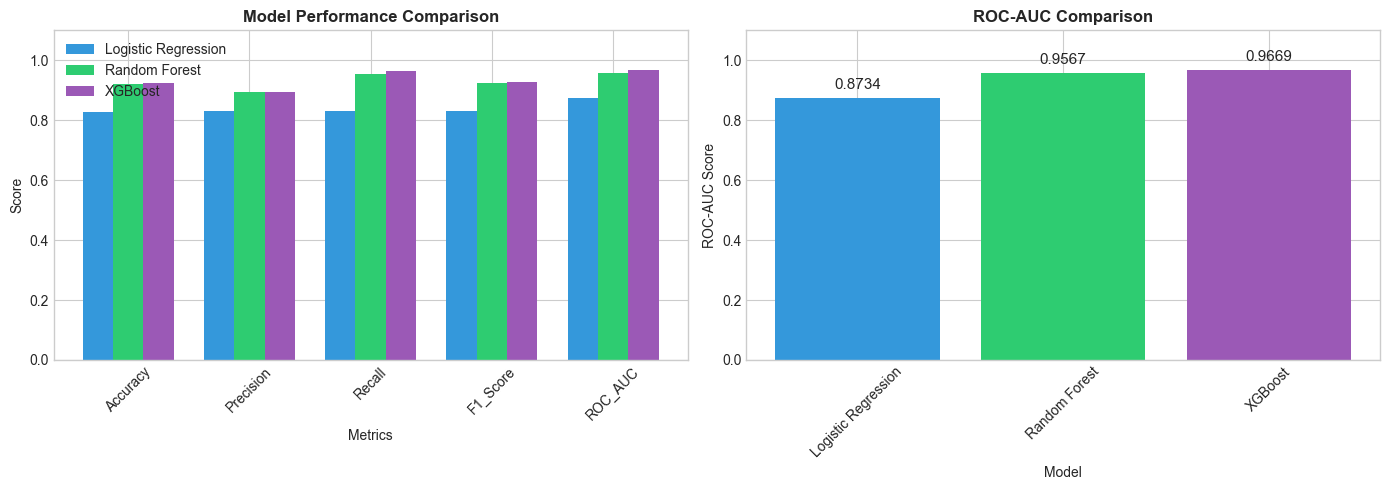


Plot saved: outputs/churn/model_comparison.png


In [14]:
# =============================================================================
# CELL 14: VISUALIZATION - MODEL COMPARISON
# =============================================================================

print("=" * 60)
print("MODEL COMPARISON VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Metrics Comparison
ax1 = axes[0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC']
x = np.arange(len(metrics))
width = 0.25

bars1 = ax1.bar(x - width, model_comparison.iloc[0][metrics], width, label='Logistic Regression', color='#3498db')
bars2 = ax1.bar(x, model_comparison.iloc[1][metrics], width, label='Random Forest', color='#2ecc71')
bars3 = ax1.bar(x + width, model_comparison.iloc[2][metrics], width, label='XGBoost', color='#9b59b6')

ax1.set_xlabel('Metrics')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45)
ax1.legend()
ax1.set_ylim(0, 1.1)

# Plot 2: ROC-AUC Comparison
ax2 = axes[1]
colors = ['#3498db', '#2ecc71', '#9b59b6']
bars = ax2.bar(model_comparison['Model'], model_comparison['ROC_AUC'], color=colors)
ax2.set_xlabel('Model')
ax2.set_ylabel('ROC-AUC Score')
ax2.set_title('ROC-AUC Comparison', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1.1)
ax2.tick_params(axis='x', rotation=45)

for bar, val in zip(bars, model_comparison['ROC_AUC']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.4f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('../outputs/churn/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/churn/model_comparison.png")

ROC CURVES


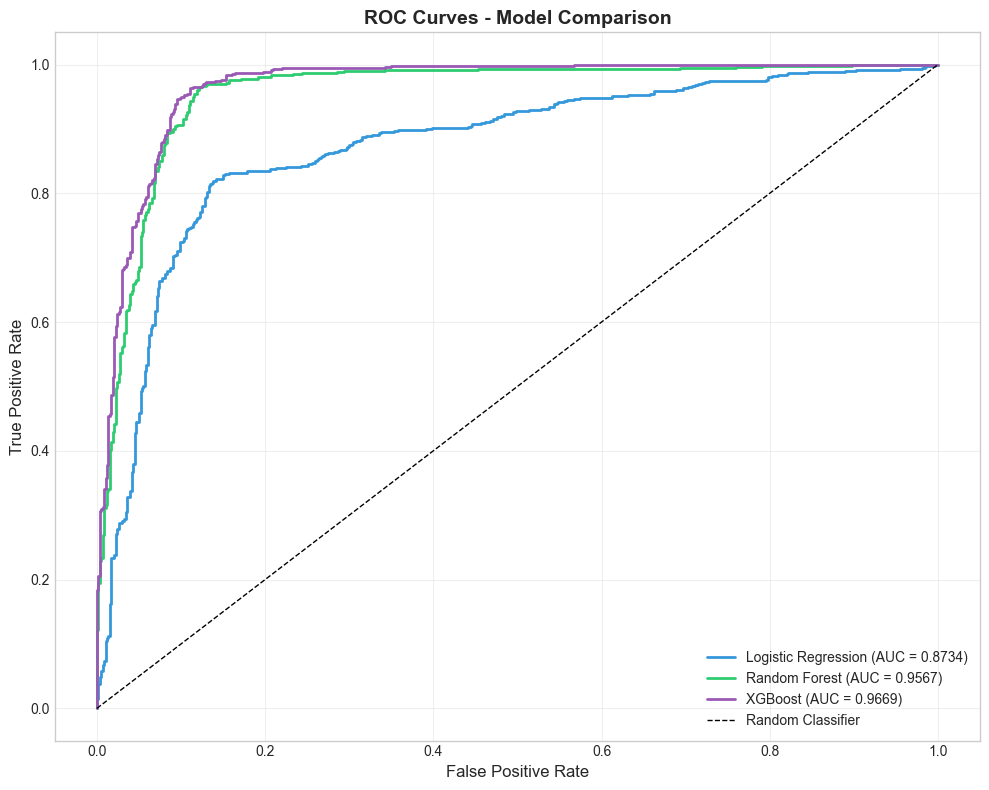


Plot saved: outputs/churn/roc_curves.png


In [15]:
# =============================================================================
# CELL 15: ROC CURVES
# =============================================================================

print("=" * 60)
print("ROC CURVES")
print("=" * 60)

fig, ax = plt.subplots(figsize=(10, 8))

# Logistic Regression ROC
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_prob)
ax.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, lr_prob):.4f})',
        color='#3498db', linewidth=2)

# Random Forest ROC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
ax.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_prob):.4f})',
        color='#2ecc71', linewidth=2)

# XGBoost ROC
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)
ax.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_prob):.4f})',
        color='#9b59b6', linewidth=2)

# Diagonal line
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/churn/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/churn/roc_curves.png")

CONFUSION MATRICES


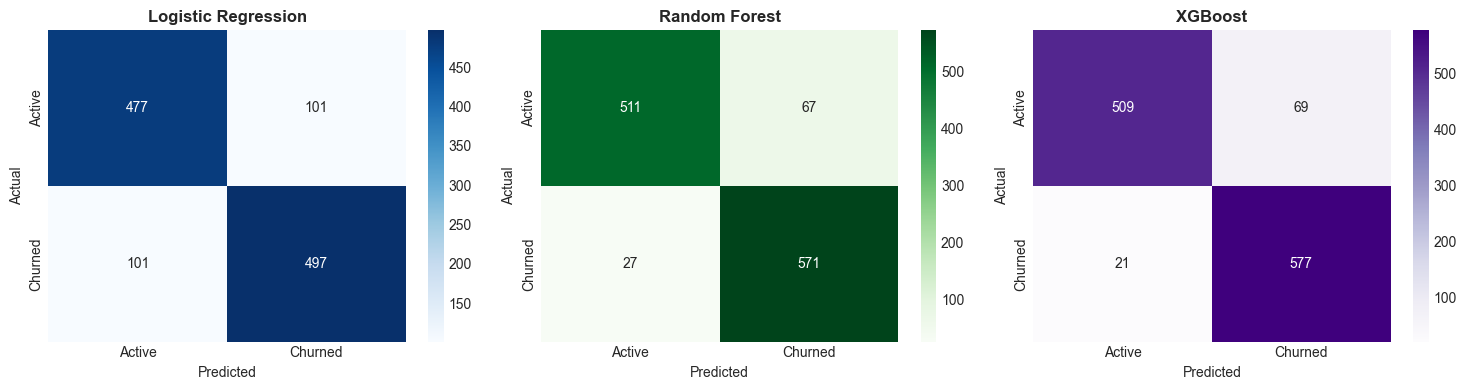


Plot saved: outputs/churn/confusion_matrices.png


In [16]:
# =============================================================================
# CELL 16: CONFUSION MATRICES
# =============================================================================

print("=" * 60)
print("CONFUSION MATRICES")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Logistic Regression
ax1 = axes[0]
cm_lr = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Active', 'Churned'], yticklabels=['Active', 'Churned'])
ax1.set_title('Logistic Regression', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Random Forest
ax2 = axes[1]
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['Active', 'Churned'], yticklabels=['Active', 'Churned'])
ax2.set_title('Random Forest', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# XGBoost
ax3 = axes[2]
cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples', ax=ax3,
            xticklabels=['Active', 'Churned'], yticklabels=['Active', 'Churned'])
ax3.set_title('XGBoost', fontsize=12, fontweight='bold')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('../outputs/churn/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/churn/confusion_matrices.png")

FEATURE IMPORTANCE - RANDOM FOREST
Top 15 Features (Random Forest):


,Feature,Importance
29,Segment_Encoded,0.4275
25,ActiveDays,0.0732
26,ActiveMonths,0.0657
0,Frequency,0.0567
6,TotalRevenue,0.0425
2,TotalOrders,0.0387
3,TotalQuantity,0.0336
1,Monetary,0.0274
14,MinPrice,0.0234
15,UniqueProducts,0.0194


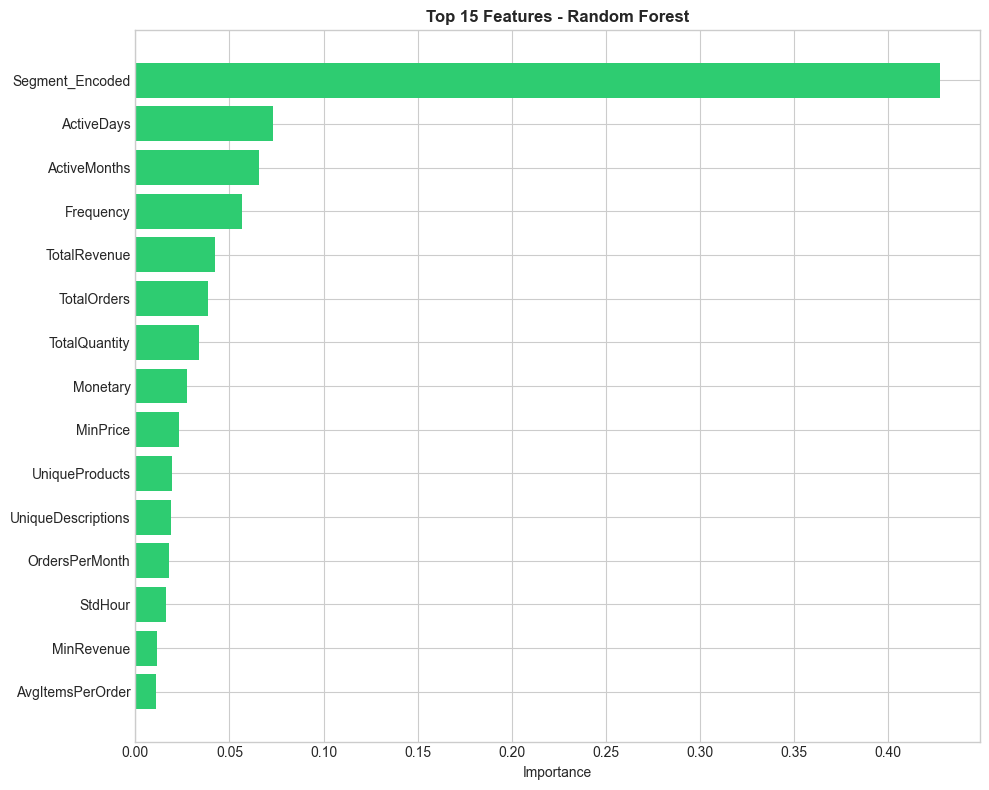


Plot saved: outputs/churn/feature_importance_rf.png


In [17]:
# =============================================================================
# CELL 17: FEATURE IMPORTANCE - RANDOM FOREST
# =============================================================================

print("=" * 60)
print("FEATURE IMPORTANCE - RANDOM FOREST")
print("=" * 60)

# Get feature importance
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 15 Features (Random Forest):")
display(rf_importance.head(15))

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 15
top_features = rf_importance.head(top_n)

bars = ax.barh(range(top_n), top_features['Importance'], color='#2ecc71')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Importance')
ax.set_title('Top 15 Features - Random Forest', fontsize=12, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../outputs/churn/feature_importance_rf.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/churn/feature_importance_rf.png")

FEATURE IMPORTANCE - XGBOOST
Top 15 Features (XGBoost):


,Feature,Importance
29,Segment_Encoded,0.5783
25,ActiveDays,0.0505
26,ActiveMonths,0.0379
14,MinPrice,0.0285
6,TotalRevenue,0.0203
2,TotalOrders,0.0193
1,Monetary,0.0163
27,OrdersPerMonth,0.0150
0,Frequency,0.0141
10,MinRevenue,0.0129


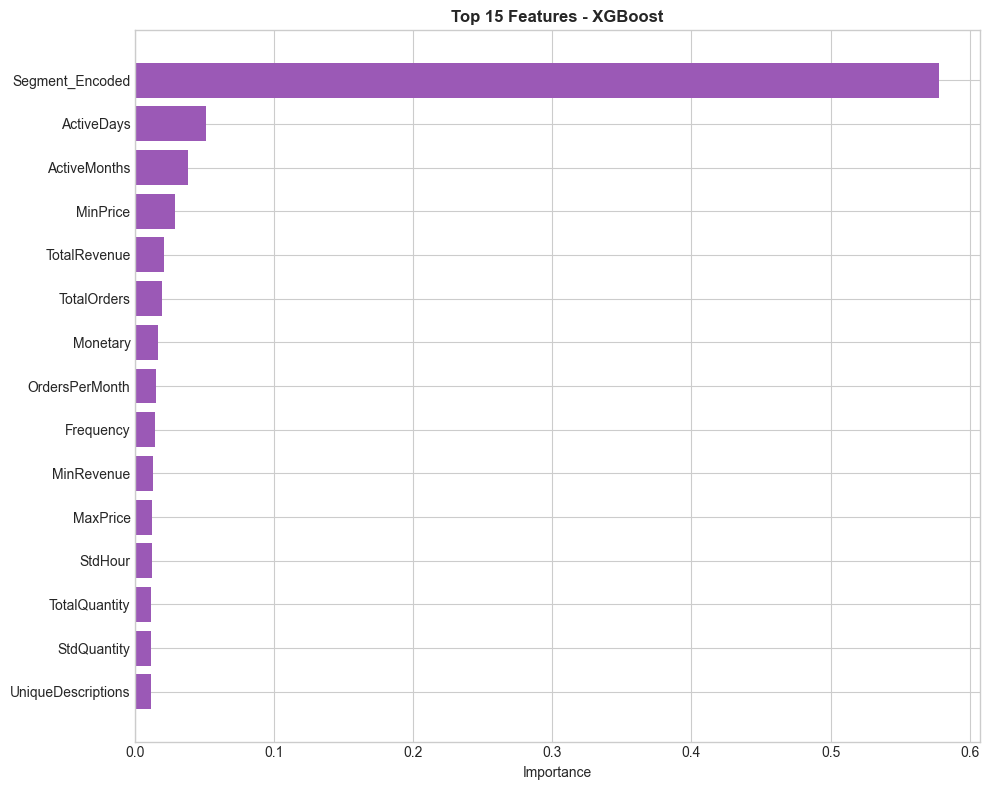


Plot saved: outputs/churn/feature_importance_xgb.png

Saved: outputs/churn/feature_importance_rf.csv
Saved: outputs/churn/feature_importance_xgb.csv


In [18]:
# =============================================================================
# CELL 18: FEATURE IMPORTANCE - XGBOOST
# =============================================================================

print("=" * 60)
print("FEATURE IMPORTANCE - XGBOOST")
print("=" * 60)

# Get feature importance
xgb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 15 Features (XGBoost):")
display(xgb_importance.head(15))

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 15
top_features = xgb_importance.head(top_n)

bars = ax.barh(range(top_n), top_features['Importance'], color='#9b59b6')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Importance')
ax.set_title('Top 15 Features - XGBoost', fontsize=12, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../outputs/churn/feature_importance_xgb.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/churn/feature_importance_xgb.png")

# Save feature importance
rf_importance.to_csv('../outputs/churn/feature_importance_rf.csv', index=False)
xgb_importance.to_csv('../outputs/churn/feature_importance_xgb.csv', index=False)
print("\nSaved: outputs/churn/feature_importance_rf.csv")
print("Saved: outputs/churn/feature_importance_xgb.csv")

SHAP ANALYSIS - MODEL EXPLAINABILITY
SHAP values calculated for 500 samples


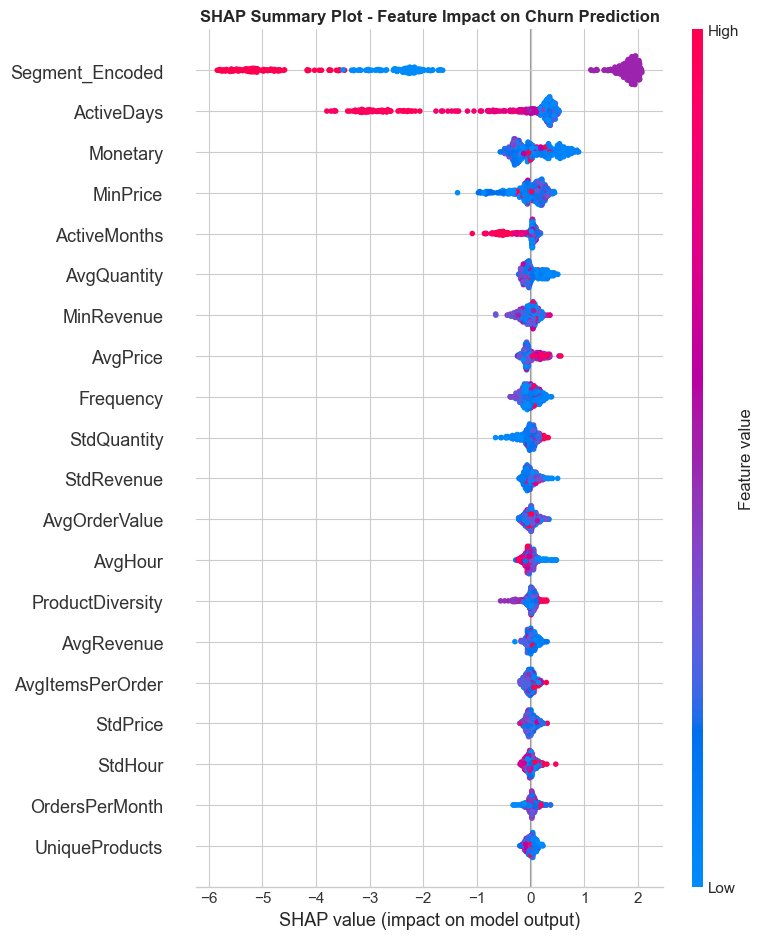


Plot saved: outputs/churn/shap_summary.png


In [19]:
# =============================================================================
# CELL 19: SHAP ANALYSIS - XGBOOST
# =============================================================================

print("=" * 60)
print("SHAP ANALYSIS - MODEL EXPLAINABILITY")
print("=" * 60)

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for test set (sample for speed)
sample_size = min(500, len(X_test_scaled))
X_sample = X_test_scaled[:sample_size]
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values calculated for {sample_size} samples")

# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Churn Prediction', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/churn/shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/churn/shap_summary.png")

SHAP FEATURE IMPORTANCE


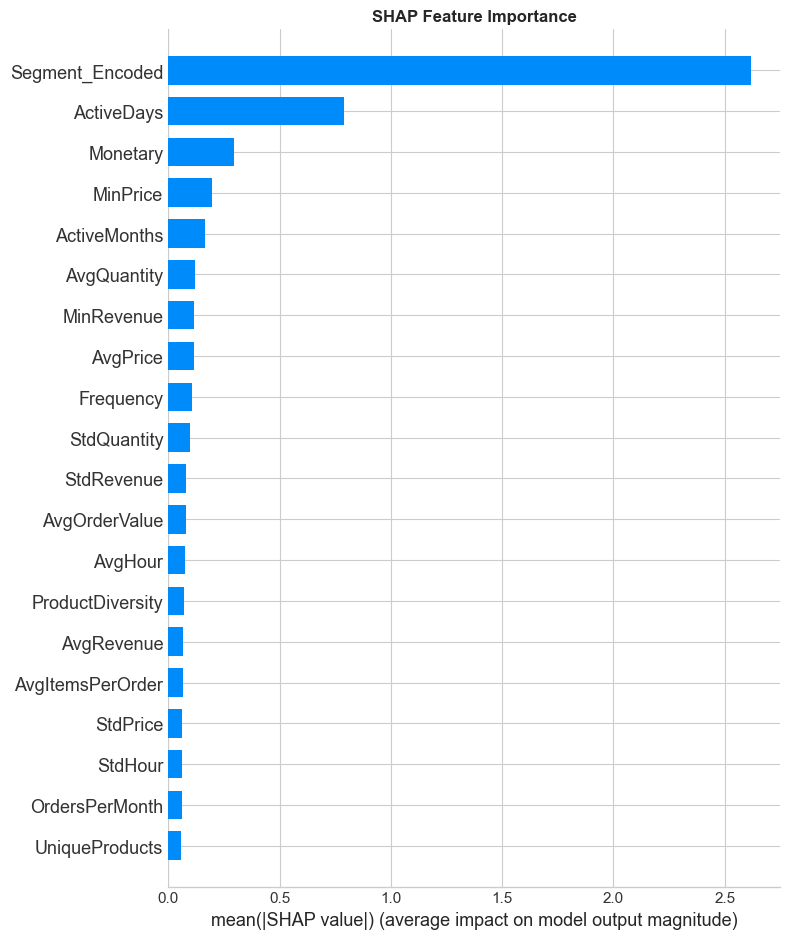


Plot saved: outputs/churn/shap_bar.png


In [20]:
# =============================================================================
# CELL 20: SHAP BAR PLOT
# =============================================================================

print("=" * 60)
print("SHAP FEATURE IMPORTANCE")
print("=" * 60)

# SHAP Bar Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, 
                  plot_type='bar', show=False)
plt.title('SHAP Feature Importance', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/churn/shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/churn/shap_bar.png")

SHAP DEPENDENCE PLOTS


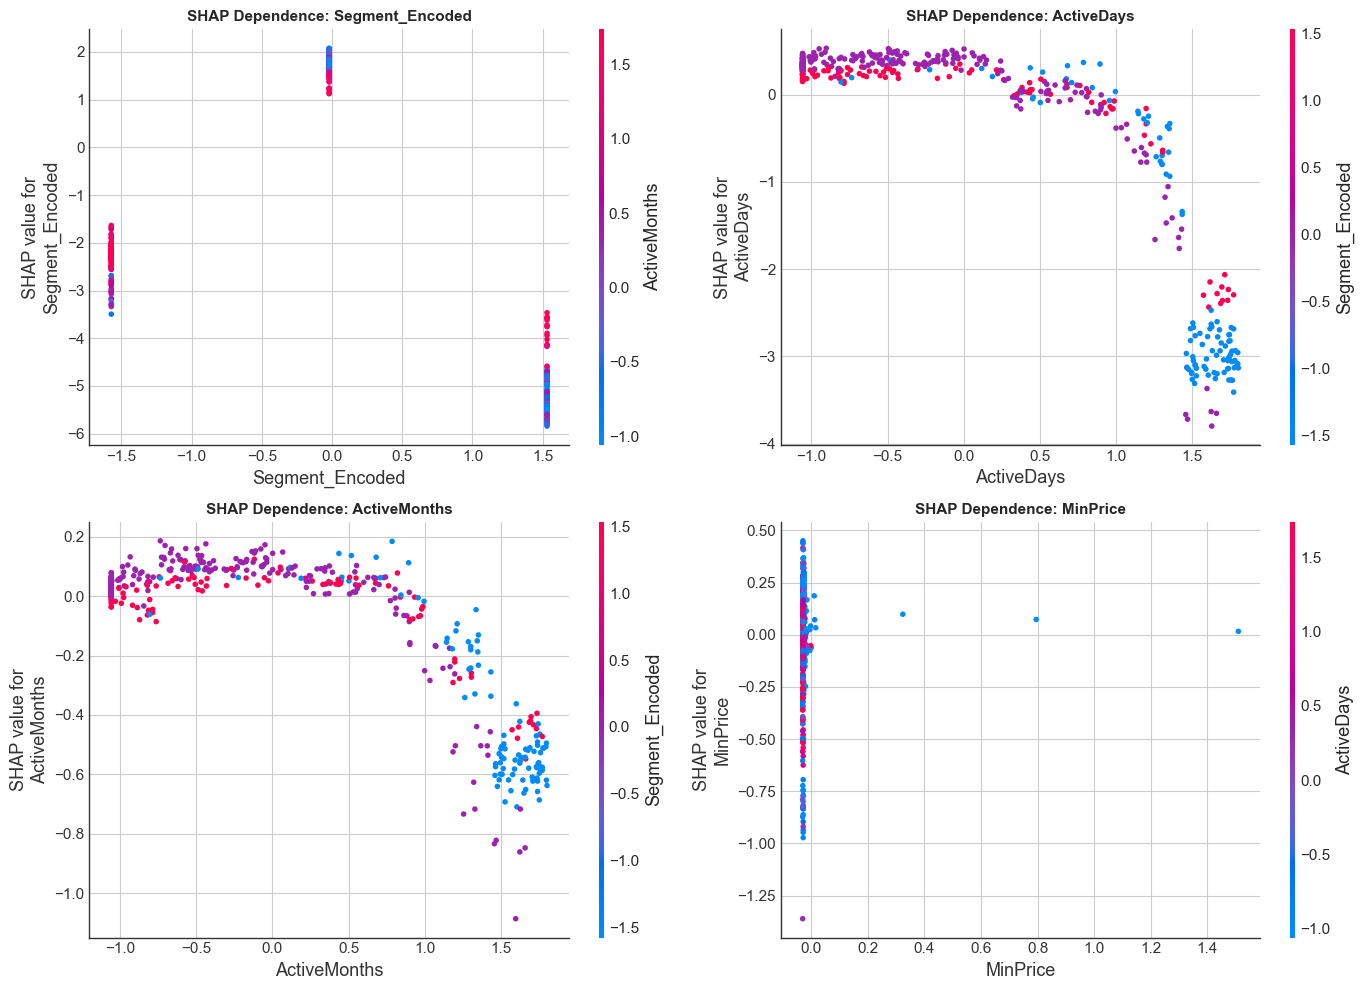


Plot saved: outputs/churn/shap_dependence.png


In [21]:
# =============================================================================
# CELL 21: SHAP DEPENDENCE PLOTS
# =============================================================================

print("=" * 60)
print("SHAP DEPENDENCE PLOTS")
print("=" * 60)

# Get top 4 features
top_4_features = xgb_importance.head(4)['Feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(top_4_features):
    feature_idx = feature_cols.index(feature)
    shap.dependence_plot(
        feature_idx, shap_values, X_sample,
        feature_names=feature_cols,
        ax=axes[i],
        show=False
    )
    axes[i].set_title(f'SHAP Dependence: {feature}', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/churn/shap_dependence.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/churn/shap_dependence.png")

In [22]:
# =============================================================================
# CELL 22: SAVE BEST MODEL
# =============================================================================

print("=" * 60)
print("SAVING BEST MODEL")
print("=" * 60)

# Select best model based on ROC-AUC
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

best_model = models[best_model_name]

# Save best model
joblib.dump(best_model, '../models/churn_model_best.pkl')
print(f"Best Model ({best_model_name}) saved: models/churn_model_best.pkl")

# Save all models
joblib.dump(lr_model, '../models/churn_logistic.pkl')
joblib.dump(rf_model, '../models/churn_random_forest.pkl')
joblib.dump(xgb_model, '../models/churn_xgboost.pkl')

print("\nAll models saved:")
print("  - churn_logistic.pkl")
print("  - churn_random_forest.pkl")
print("  - churn_xgboost.pkl")
print("  - churn_model_best.pkl")

SAVING BEST MODEL
Best Model (XGBoost) saved: models/churn_model_best.pkl

All models saved:
  - churn_logistic.pkl
  - churn_random_forest.pkl
  - churn_xgboost.pkl
  - churn_model_best.pkl


In [23]:
# =============================================================================
# CELL 23: GENERATE CHURN PREDICTIONS FOR ALL CUSTOMERS
# =============================================================================

print("=" * 60)
print("GENERATING PREDICTIONS FOR ALL CUSTOMERS")
print("=" * 60)

# Scale all features
X_all_scaled = scaler.transform(X)

# Get predictions from best model (XGBoost)
churn_predictions = xgb_model.predict(X_all_scaled)
churn_probabilities = xgb_model.predict_proba(X_all_scaled)[:, 1]

# Add to churn_data
churn_data['Churn_Predicted'] = churn_predictions
churn_data['Churn_Probability'] = churn_probabilities

# Risk categories
def categorize_risk(prob):
    if prob < 0.3:
        return 'Low Risk'
    elif prob < 0.6:
        return 'Medium Risk'
    else:
        return 'High Risk'

churn_data['Risk_Category'] = churn_data['Churn_Probability'].apply(categorize_risk)

# Risk distribution
print("\nRisk Category Distribution:")
risk_dist = churn_data['Risk_Category'].value_counts()
for cat, count in risk_dist.items():
    pct = count / len(churn_data) * 100
    print(f"  {cat}: {count:,} customers ({pct:.1f}%)")

# Display sample high-risk customers
print("\nTop 10 High-Risk Customers:")
high_risk = churn_data[churn_data['Risk_Category'] == 'High Risk'].nlargest(10, 'Churn_Probability')
display(high_risk[['CustomerID', 'Segment', 'Churn_Probability', 'Risk_Category', 
                   'Monetary', 'Frequency', 'TotalOrders']])

GENERATING PREDICTIONS FOR ALL CUSTOMERS

Risk Category Distribution:
  High Risk: 3,049 customers (51.9%)
  Low Risk: 2,572 customers (43.8%)
  Medium Risk: 257 customers (4.4%)

Top 10 High-Risk Customers:


,CustomerID,Segment,Churn_Probability,Risk_Category,Monetary,Frequency,TotalOrders
5116,17518,Hibernating,0.9958,High Risk,329.4200,2,2
5639,18049,Hibernating,0.9956,High Risk,500.9200,2,2
3040,15418,Hibernating,0.9951,High Risk,449.4200,2,2
2504,14877,Hibernating,0.9950,High Risk,425.8500,2,2
2029,14398,Hibernating,0.9948,High Risk,707.7900,2,2
3322,15700,Hibernating,0.9946,High Risk,696.6800,2,2
2278,14647,Hibernating,0.9944,High Risk,506.0400,2,2
1255,13616,Hibernating,0.9943,High Risk,283.8500,2,2
5727,18137,Hibernating,0.9942,High Risk,145.9900,2,2
5198,17601,Hibernating,0.9941,High Risk,413.0800,2,2


RISK DISTRIBUTION VISUALIZATION


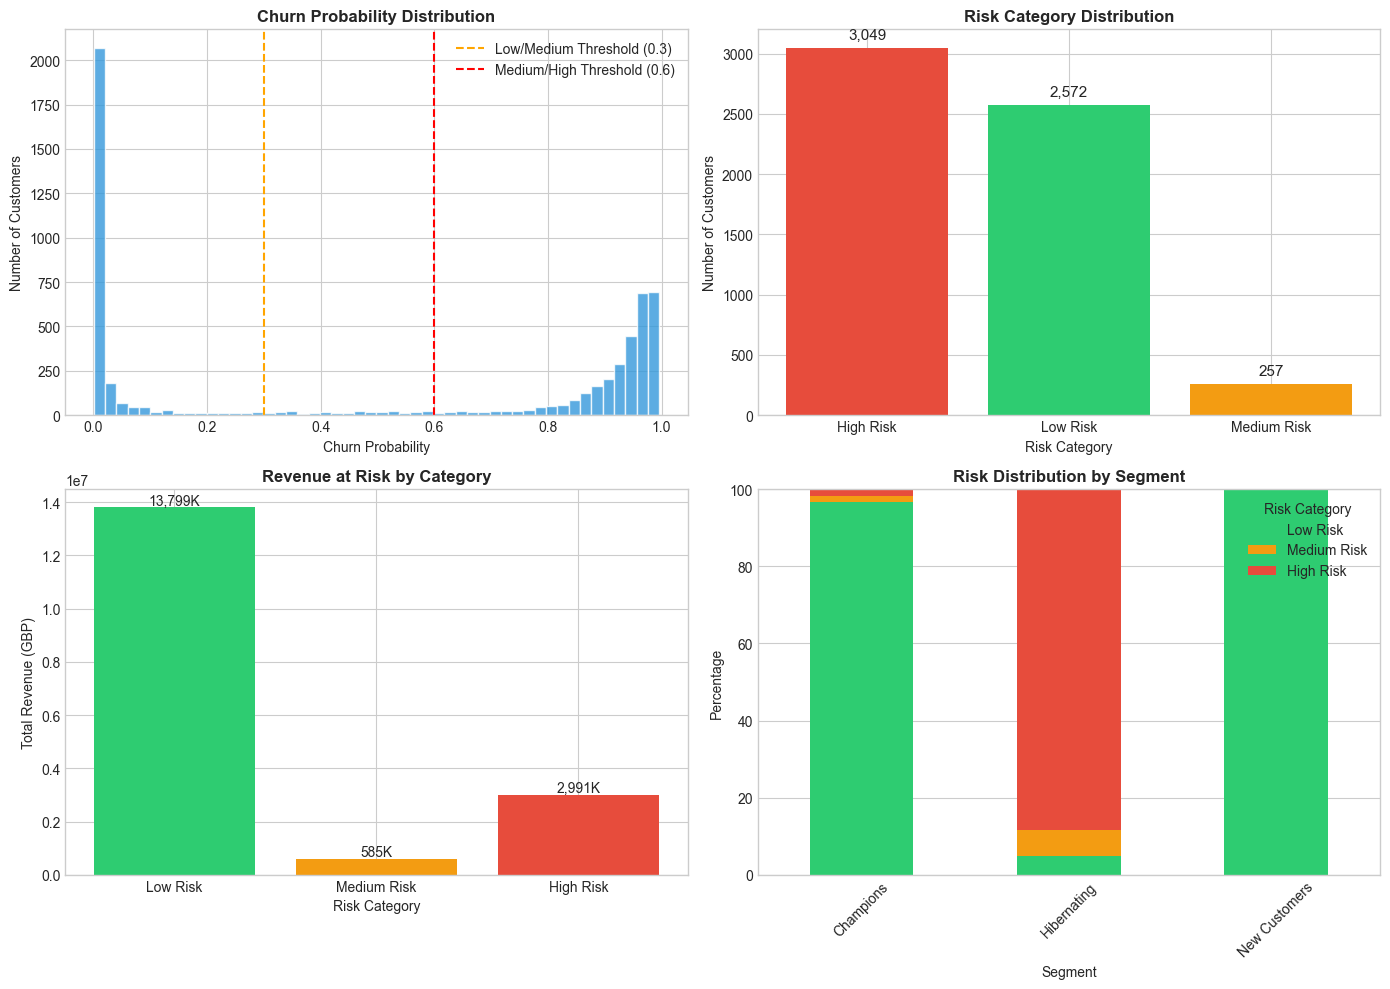


Plot saved: outputs/churn/risk_distribution.png


In [24]:
# =============================================================================
# CELL 24: RISK DISTRIBUTION VISUALIZATION
# =============================================================================

print("=" * 60)
print("RISK DISTRIBUTION VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Churn Probability Distribution
ax1 = axes[0, 0]
ax1.hist(churn_data['Churn_Probability'], bins=50, color='#3498db', edgecolor='white', alpha=0.8)
ax1.axvline(0.3, color='orange', linestyle='--', label='Low/Medium Threshold (0.3)')
ax1.axvline(0.6, color='red', linestyle='--', label='Medium/High Threshold (0.6)')
ax1.set_xlabel('Churn Probability')
ax1.set_ylabel('Number of Customers')
ax1.set_title('Churn Probability Distribution', fontsize=12, fontweight='bold')
ax1.legend()

# Plot 2: Risk Category Distribution
ax2 = axes[0, 1]
risk_colors = {'Low Risk': '#2ecc71', 'Medium Risk': '#f39c12', 'High Risk': '#e74c3c'}
risk_counts = churn_data['Risk_Category'].value_counts()
bars = ax2.bar(risk_counts.index, risk_counts.values, 
               color=[risk_colors[x] for x in risk_counts.index])
ax2.set_xlabel('Risk Category')
ax2.set_ylabel('Number of Customers')
ax2.set_title('Risk Category Distribution', fontsize=12, fontweight='bold')
for bar, val in zip(bars, risk_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{val:,}', ha='center', va='bottom', fontsize=11)

# Plot 3: Revenue by Risk Category
ax3 = axes[1, 0]
revenue_by_risk = churn_data.groupby('Risk_Category')['Monetary'].sum()
revenue_by_risk = revenue_by_risk.reindex(['Low Risk', 'Medium Risk', 'High Risk'])
bars = ax3.bar(revenue_by_risk.index, revenue_by_risk.values,
               color=[risk_colors[x] for x in revenue_by_risk.index])
ax3.set_xlabel('Risk Category')
ax3.set_ylabel('Total Revenue (GBP)')
ax3.set_title('Revenue at Risk by Category', fontsize=12, fontweight='bold')
for bar, val in zip(bars, revenue_by_risk.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{val/1000:,.0f}K', ha='center', va='bottom', fontsize=10)

# Plot 4: Risk by Segment
ax4 = axes[1, 1]
segment_risk = pd.crosstab(churn_data['Segment'], churn_data['Risk_Category'], normalize='index') * 100
segment_risk = segment_risk[['Low Risk', 'Medium Risk', 'High Risk']]
segment_risk.plot(kind='bar', stacked=True, ax=ax4, 
                  color=[risk_colors['Low Risk'], risk_colors['Medium Risk'], risk_colors['High Risk']])
ax4.set_xlabel('Segment')
ax4.set_ylabel('Percentage')
ax4.set_title('Risk Distribution by Segment', fontsize=12, fontweight='bold')
ax4.legend(title='Risk Category', loc='upper right')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../outputs/churn/risk_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved: outputs/churn/risk_distribution.png")

In [25]:
# =============================================================================
# CELL 25: SAVE OUTPUTS
# =============================================================================

print("=" * 60)
print("SAVING OUTPUTS")
print("=" * 60)

# 1. Full churn predictions
churn_output = churn_data[['CustomerID', 'Segment', 'Churn', 'Churn_Predicted', 
                            'Churn_Probability', 'Risk_Category', 
                            'Monetary', 'Frequency', 'TotalRevenue']].copy()
churn_output.to_csv('../outputs/churn/churn_predictions.csv', index=False)
print("Saved: outputs/churn/churn_predictions.csv")

# 2. High-risk customers
high_risk_customers = churn_data[churn_data['Risk_Category'] == 'High Risk'][
    ['CustomerID', 'Segment', 'Churn_Probability', 'Monetary', 'Frequency', 'TotalRevenue']
].sort_values('Churn_Probability', ascending=False)
high_risk_customers.to_csv('../outputs/churn/high_risk_customers.csv', index=False)
print("Saved: outputs/churn/high_risk_customers.csv")

# 3. Model metrics
metrics_output = model_comparison.copy()
metrics_output.to_csv('../outputs/churn/churn_metrics.csv', index=False)
print("Saved: outputs/churn/churn_metrics.csv")

# 4. Power BI export
churn_pbi = churn_data[['CustomerID', 'Segment', 'Churn_Probability', 
                         'Risk_Category', 'Monetary', 'Frequency']].copy()
churn_pbi.to_csv('../outputs/powerbi/churn_for_pbi.csv', index=False)
print("Saved: outputs/powerbi/churn_for_pbi.csv")

# Risk summary for Power BI
risk_summary = churn_data.groupby('Risk_Category').agg({
    'CustomerID': 'count',
    'Monetary': 'sum',
    'Churn_Probability': 'mean'
}).reset_index()
risk_summary.columns = ['Risk_Category', 'Customer_Count', 'Total_Revenue', 'Avg_Probability']
risk_summary.to_csv('../outputs/powerbi/risk_summary_pbi.csv', index=False)
print("Saved: outputs/powerbi/risk_summary_pbi.csv")

print("\nAll churn prediction outputs saved successfully")

SAVING OUTPUTS
Saved: outputs/churn/churn_predictions.csv
Saved: outputs/churn/high_risk_customers.csv
Saved: outputs/churn/churn_metrics.csv
Saved: outputs/powerbi/churn_for_pbi.csv
Saved: outputs/powerbi/risk_summary_pbi.csv

All churn prediction outputs saved successfully


In [26]:
# =============================================================================
# CELL 26: SUMMARY REPORT
# =============================================================================

print("=" * 70)
print("NOTEBOOK 05 - CHURN PREDICTION SUMMARY REPORT")
print("=" * 70)

# Calculate key stats
total_customers = len(churn_data)
churned_actual = churn_data['Churn'].sum()
high_risk_count = len(churn_data[churn_data['Risk_Category'] == 'High Risk'])
high_risk_revenue = churn_data[churn_data['Risk_Category'] == 'High Risk']['Monetary'].sum()

report = f"""
-----------------------------------------------------------------------------
                     CHURN PREDICTION SUMMARY
-----------------------------------------------------------------------------

DATA OVERVIEW
-----------------------------------------
Total Customers:         {total_customers:,}
Churned (Actual):        {churned_actual:,} ({churned_actual/total_customers*100:.1f}%)
Churn Threshold:         {CHURN_THRESHOLD} days

MODEL PERFORMANCE (Best Model: {best_model_name})
-----------------------------------------
Accuracy:                {model_comparison.loc[best_model_idx, 'Accuracy']:.4f}
Precision:               {model_comparison.loc[best_model_idx, 'Precision']:.4f}
Recall:                  {model_comparison.loc[best_model_idx, 'Recall']:.4f}
F1 Score:                {model_comparison.loc[best_model_idx, 'F1_Score']:.4f}
ROC-AUC:                 {model_comparison.loc[best_model_idx, 'ROC_AUC']:.4f}

RISK DISTRIBUTION
-----------------------------------------
"""

for cat in ['Low Risk', 'Medium Risk', 'High Risk']:
    count = len(churn_data[churn_data['Risk_Category'] == cat])
    pct = count / total_customers * 100
    rev = churn_data[churn_data['Risk_Category'] == cat]['Monetary'].sum()
    report += f"{cat:15} {count:>6,} ({pct:>5.1f}%)  Revenue: {rev:>12,.0f} GBP\n"

report += f"""
HIGH-RISK CUSTOMERS
-----------------------------------------
Count:                   {high_risk_count:,}
Revenue at Risk:         {high_risk_revenue:,.2f} GBP

TOP CHURN PREDICTORS (XGBoost)
-----------------------------------------
"""

for i, row in xgb_importance.head(5).iterrows():
    report += f"  {row['Feature']:25} {row['Importance']:.4f}\n"

report += f"""
FILES GENERATED
-----------------------------------------
Models:
  - churn_model_best.pkl ({best_model_name})
  - churn_logistic.pkl
  - churn_random_forest.pkl
  - churn_xgboost.pkl
  - churn_scaler.pkl

Visualizations:
  - churn_distribution.png
  - model_comparison.png
  - roc_curves.png
  - confusion_matrices.png
  - feature_importance_rf.png
  - feature_importance_xgb.png
  - shap_summary.png
  - shap_bar.png
  - shap_dependence.png
  - risk_distribution.png

CSV Files:
  - churn_predictions.csv
  - high_risk_customers.csv
  - churn_metrics.csv
  - feature_importance_rf.csv
  - feature_importance_xgb.csv
  - model_comparison.csv
  - churn_for_pbi.csv
  - risk_summary_pbi.csv

-----------------------------------------------------------------------------
PROJECT COMPLETE - READY FOR POWER BI DASHBOARD
-----------------------------------------------------------------------------
"""

print(report)

NOTEBOOK 05 - CHURN PREDICTION SUMMARY REPORT

-----------------------------------------------------------------------------
                     CHURN PREDICTION SUMMARY
-----------------------------------------------------------------------------

DATA OVERVIEW
-----------------------------------------
Total Customers:         5,878
Churned (Actual):        2,989 (50.9%)
Churn Threshold:         90 days

MODEL PERFORMANCE (Best Model: XGBoost)
-----------------------------------------
Accuracy:                0.9235
Precision:               0.8932
Recall:                  0.9649
F1 Score:                0.9277
ROC-AUC:                 0.9669

RISK DISTRIBUTION
-----------------------------------------
Low Risk         2,572 ( 43.8%)  Revenue:   13,799,467 GBP
Medium Risk        257 (  4.4%)  Revenue:      584,595 GBP
High Risk        3,049 ( 51.9%)  Revenue:    2,990,742 GBP

HIGH-RISK CUSTOMERS
-----------------------------------------
Count:                   3,049
Revenue at Risk: